In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai langgraph_sdk serpapi sendgrid langchain_openai


In [2]:
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KET')
SERPAPI_API_KEY = userdata.get('SERPAPI_API_KEY')
SENDGRID_API_KEY = userdata.get('SENDGRID_API_KEY')
open_api_key = userdata.get('OPENAI_API_KEY')

In [3]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", api_key=open_api_key)
llm.invoke("greet me")



/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


AIMessage(content='Hello! How are you today? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 10, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-d28b4b54-03f4-4e09-8d26-12fdd8e36760-0', usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from typing import TypedDict, Annotated, List
from langgraph.graph import MessagesState
from langchain_core.prompts import ChatPromptTemplate

In [6]:
from langgraph.graph import MessagesState
class AgentState(MessagesState):
    pass



In [7]:
import datetime
import operator

CURRENT_YEAR = datetime.datetime.now().year

TOOLS_SYSTEM_PROMPT = f"""You are a smart travel agency. Use the tools to look up information.
    You are allowed to make multiple calls (either together or in sequence).
    Only look up information when you are sure of what you want.
    The current year is {CURRENT_YEAR}.
    If you need to look up some information before asking a follow up question, you are allowed to do that!
    I want to have in your output links to hotels websites and flights websites (if possible).
    I want to have as well the logo of the hotel and the logo of the airline company (if possible).
    In your output always include the price of the flight and the price of the hotel and the currency as well (if possible).
    for example for hotels-
    Rate: $581 per night
    Total: $3,488
    """

EMAILS_SYSTEM_PROMPT = """Your task is to convert structured markdown-like text into a valid HTML email body.

- Do not include a ```html preamble in your response.
- The output should be in proper HTML format, ready to be used as the body of an email.
Here is an example:
<example>
Input:

I want to travel to New York from Madrid from October 1-7. Find me flights and 4-star hotels.

Expected Output:

<!DOCTYPE html>
<html>
<head>
    <title>Flight and Hotel Options</title>
</head>
<body>
    <h2>Flights from Madrid to New York</h2>
    <ol>
        <li>
            <strong>American Airlines</strong><br>
            <strong>Departure:</strong> Adolfo Suárez Madrid–Barajas Airport (MAD) at 10:25 AM<br>
            <strong>Arrival:</strong> John F. Kennedy International Airport (JFK) at 12:25 PM<br>
            <strong>Duration:</strong> 8 hours<br>
            <strong>Aircraft:</strong> Boeing 777<br>
            <strong>Class:</strong> Economy<br>
            <strong>Price:</strong> $702<br>
            <img src="https://www.gstatic.com/flights/airline_logos/70px/AA.png" alt="American Airlines"><br>
            <a href="https://www.google.com/flights">Book on Google Flights</a>
        </li>
        <li>
            <strong>Iberia</strong><br>
            <strong>Departure:</strong> Adolfo Suárez Madrid–Barajas Airport (MAD) at 12:25 PM<br>
            <strong>Arrival:</strong> John F. Kennedy International Airport (JFK) at 2:40 PM<br>
            <strong>Duration:</strong> 8 hours 15 minutes<br>
            <strong>Aircraft:</strong> Airbus A330<br>
            <strong>Class:</strong> Economy<br>
            <strong>Price:</strong> $702<br>
            <img src="https://www.gstatic.com/flights/airline_logos/70px/IB.png" alt="Iberia"><br>
            <a href="https://www.google.com/flights">Book on Google Flights</a>
        </li>
        <li>
            <strong>Delta Airlines</strong><br>
            <strong>Departure:</strong> Adolfo Suárez Madrid–Barajas Airport (MAD) at 10:00 AM<br>
            <strong>Arrival:</strong> John F. Kennedy International Airport (JFK) at 12:30 PM<br>
            <strong>Duration:</strong> 8 hours 30 minutes<br>
            <strong>Aircraft:</strong> Boeing 767<br>
            <strong>Class:</strong> Economy<br>
            <strong>Price:</strong> $738<br>
            <img src="https://www.gstatic.com/flights/airline_logos/70px/DL.png" alt="Delta Airlines"><br>
            <a href="https://www.google.com/flights">Book on Google Flights</a>
        </li>
    </ol>

    <h2>4-Star Hotels in New York</h2>
    <ol>
        <li>
            <strong>NobleDen Hotel</strong><br>
            <strong>Description:</strong> Modern, polished hotel offering sleek rooms, some with city-view balconies, plus free Wi-Fi.<br>
            <strong>Location:</strong> Near Washington Square Park, Grand St, and JFK Airport.<br>
            <strong>Rate per Night:</strong> $537<br>
            <strong>Total Rate:</strong> $3,223<br>
            <strong>Rating:</strong> 4.8/5 (656 reviews)<br>
            <strong>Amenities:</strong> Free Wi-Fi, Parking, Air conditioning, Restaurant, Accessible, Business centre, Child-friendly, Smoke-free property<br>
            <img src="https://lh5.googleusercontent.com/p/AF1QipNDUrPJwBhc9ysDhc8LA822H1ZzapAVa-WDJ2d6=s287-w287-h192-n-k-no-v1" alt="NobleDen Hotel"><br>
            <a href="http://www.nobleden.com/">Visit Website</a>
        </li>
        <!-- More hotel entries here -->
    </ol>
</body>
</html>

</example>


"""

In [8]:
from langchain_core.tools import tool

from typing import Optional

from pydantic import BaseModel, Field
import serpapi
# from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool


class FlightsInput(BaseModel):
    departure_airport: Optional[str] = Field(description='Departure airport code (IATA)')
    arrival_airport: Optional[str] = Field(description='Arrival airport code (IATA)')
    outbound_date: Optional[str] = Field(description='Parameter defines the outbound date. The format is YYYY-MM-DD. e.g. 2024-06-22')
    return_date: Optional[str] = Field(description='Parameter defines the return date. The format is YYYY-MM-DD. e.g. 2024-06-28')
    adults: Optional[int] = Field(1, description='Parameter defines the number of adults. Default to 1.')
    children: Optional[int] = Field(0, description='Parameter defines the number of children. Default to 0.')
    infants_in_seat: Optional[int] = Field(0, description='Parameter defines the number of infants in seat. Default to 0.')
    infants_on_lap: Optional[int] = Field(0, description='Parameter defines the number of infants on lap. Default to 0.')


class FlightsInputSchema(BaseModel):
    params: FlightsInput


@tool(args_schema=FlightsInputSchema)
def flights_finder(params: FlightsInput):
    '''
    Find flights using the Google Flights engine.

    Returns:
        dict: Flight search results.
    '''

    params = {
        'api_key': SERPAPI_API_KEY,
        'engine': 'google_flights',
        'hl': 'en',
        'gl': 'us',
        'departure_id': params.departure_airport,
        'arrival_id': params.arrival_airport,
        'outbound_date': params.outbound_date,
        'return_date': params.return_date,
        'currency': 'USD',
        'adults': params.adults,
        'infants_in_seat': params.infants_in_seat,
        'stops': '1',
        'infants_on_lap': params.infants_on_lap,
        'children': params.children
    }

    try:
        search = serpapi.search(params)
        results = search.data['best_flights']
    except Exception as e:
        results = str(e)
    return results

In [11]:
import os
from typing import Optional

import serpapi
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool

# from pydantic import BaseModel, Field


class HotelsInput(BaseModel):
    q: str = Field(description='Location of the hotel')
    check_in_date: str = Field(description='Check-in date. The format is YYYY-MM-DD. e.g. 2024-06-22')
    check_out_date: str = Field(description='Check-out date. The format is YYYY-MM-DD. e.g. 2024-06-28')
    sort_by: Optional[str] = Field(8, description='Parameter is used for sorting the results. Default is sort by highest rating')
    adults: Optional[int] = Field(1, description='Number of adults. Default to 1.')
    children: Optional[int] = Field(0, description='Number of children. Default to 0.')
    rooms: Optional[int] = Field(1, description='Number of rooms. Default to 1.')
    hotel_class: Optional[str] = Field(
        None, description='Parameter defines to include only certain hotel class in the results. for example- 2,3,4')


class HotelsInputSchema(BaseModel):
    params: HotelsInput


@tool(args_schema=HotelsInputSchema)
def hotels_finder(params: HotelsInput):
    '''
    Find hotels using the Google Hotels engine.

    Returns:
        dict: Hotel search results.
    '''

    params = {
        'api_key': SERPAPI_API_KEY,
        'engine': 'google_hotels',
        'hl': 'en',
        'gl': 'us',
        'q': params.q,
        'check_in_date': params.check_in_date,
        'check_out_date': params.check_out_date,
        'currency': 'USD',
        'adults': params.adults,
        'children': params.children,
        'rooms': params.rooms,
        'sort_by': params.sort_by,
        'hotel_class': params.hotel_class
    }

    search = serpapi.search(params)
    results = search.data
    return results['properties'][:5]

In [12]:
tools: list[tool] = [flights_finder, hotels_finder]

llm_with_tools = llm.bind_tools(tools)

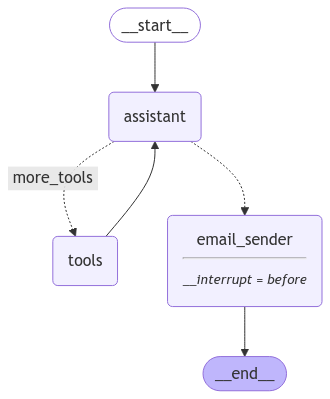

In [15]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import StateGraph, END ,START
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph
from sendgrid import SendGridAPIClient
from sendgrid.helpers.mail import Mail


def assistant(state: AgentState):
        messages = state['messages']
        messages = [SystemMessage(content=TOOLS_SYSTEM_PROMPT)] + messages
        message = llm_with_tools.invoke(messages)
        return {'messages': [message]}

# def invoke_tools(self, state: AgentState):
#         tool_calls = state['messages'][-1].tool_calls
#         results = []
#         for t in tool_calls:
#             print(f'Calling: {t}')
#             if not t['name'] in self._tools:  # check for bad tool name from LLM
#                 print('\n ....bad tool name....')
#                 result = 'bad tool name, retry'  # instruct LLM to retry if bad
#             else:
#                 result = self._tools[t['name']].invoke(t['args'])
#             results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
#         print('Back to the model!')
#         return {'messages': results}

def exists_action(state: AgentState):
        result = state['messages'][-1]
        if len(result.tool_calls) == 0:
            return 'email_sender'
        return 'more_tools'


def email_sender(state: AgentState):
        print('Sending email')
        # email_llm = ChatOpenAI(model='gpt-4o', temperature=0.1)  # Instantiate another LLM
        email_message = [SystemMessage(content=EMAILS_SYSTEM_PROMPT), HumanMessage(content=state['messages'][-1].content)]
        email_response = llm.invoke(email_message)
        print('Email content:', email_response.content)

        # message = Mail(from_email=os.environ['FROM_EMAIL'], to_emails=os.environ['TO_EMAIL'], subject=os.environ['EMAIL_SUBJECT'],
        #                html_content=email_response.content)

        message = Mail(from_email="areeb.ahmed.langgraph@gmail.com", to_emails="areebahmed575@gmail.com", subject="Static Email Subject",
                       html_content=email_response.content)


        try:
            sg = SendGridAPIClient(SENDGRID_API_KEY)
            response = sg.send(message)
            print(response.status_code)
            print(response.body)
            print(response.headers)
        except Exception as e:
            print(str(e))





# Graph
builder: StateGraph = StateGraph(MessagesState)


# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node('email_sender', email_sender)

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
# builder.add_conditional_edges(
#     "assistant",
#     # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
#     tools_condition,
# )
builder.add_conditional_edges('assistant', exists_action, {'more_tools': 'tools', 'email_sender': 'email_sender'})
builder.add_edge("tools", "assistant")
builder.add_edge('email_sender', END)

memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile(interrupt_before=["email_sender"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [16]:
# Input
initial_input = {"messages": HumanMessage(content="I want to travel to Dubai from Karachi from 20 - 27 Febuary.Find me flights and 4 star hotels")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

I want to travel to Dubai from Karachi from 20 - 27 Febuary.Find me flights and 4 star hotels


================================== Ai Message ==================================
Tool Calls:
  flights_finder (call_6mcslCG1YSa9CAdtoHuuauo9)
 Call ID: call_6mcslCG1YSa9CAdtoHuuauo9
  Args:
    params: {'departure_airport': 'KHI', 'arrival_airport': 'DXB', 'outbound_date': '2025-02-20', 'return_date': '2025-02-27'}
  hotels_finder (call_TQtEJA8UnMvUpiC3rbdsZuYF)
 Call ID: call_TQtEJA8UnMvUpiC3rbdsZuYF
  Args:
    params: {'q': 'Dubai', 'check_in_date': '2025-02-20', 'check_out_date': '2025-02-27', 'hotel_class': '4', 'sort_by': '8'}
================================= Tool Message =================================
Name: hotels_finder

[{"type": "hotel", "name": "Holiday Inn & Suites Dubai Festival City, an IHG Hotel", "description": "Airy quarters in a contemporary hotel with a restaurant & a cafe, plus a rooftop pool with a bar.", "link": "https://www.ihg.com/holidayinn/hotels/gb/en/dubai/dxbfc/hoteldetail?cm_mmc=GoogleMaps-_-HI-_-AE-_-DXBFC", "property_token": "ChkI8-b44eSkmdwbGg0vZy8x

================================== Ai Message ==================================

### Flights from Karachi to Dubai

#### Option 1: Pakistan International Airlines
- **Flight Number**: PK 213
- **Departure**: February 20, 2025, at 01:10 KHI
- **Arrival**: February 20, 2025, at 02:45 DXB
- **Duration**: 155 minutes
- **Price**: **$356**
- [Airline Logo](https://www.gstatic.com/flights/airline_logos/70px/PK.png)

---

#### Option 2: Airblue
- **Flight Number**: PA 110
- **Departure**: February 20, 2025, at 18:10 KHI
- **Arrival**: February 20, 2025, at 19:40 DXB
- **Duration**: 150 minutes
- **Price**: **$401**
- [Airline Logo](https://www.gstatic.com/flights/airline_logos/70px/PA.png)

---

#### Option 3: flydubai
- **Flight Number**: FZ 330
- **Departure**: February 20, 2025, at 23:45 KHI
- **Arrival**: February 21, 2025, at 01:20 DXB
- **Duration**: 155 minutes
- **Price**: **$421**
- [Airline Logo](https://www.gstatic.com/flights/airline_logos/70px/FZ.png)

### Four-Star Hotels in Du

In [17]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='I want to travel to Dubai from Karachi from 20 - 27 Febuary.Find me flights and 4 star hotels', additional_kwargs={}, response_metadata={}, id='c40ab10f-6464-4d0b-9883-b0f9c2ec29ee'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6mcslCG1YSa9CAdtoHuuauo9', 'function': {'arguments': '{"params": {"departure_airport": "KHI", "arrival_airport": "DXB", "outbound_date": "2025-02-20", "return_date": "2025-02-27"}}', 'name': 'flights_finder'}, 'type': 'function'}, {'id': 'call_TQtEJA8UnMvUpiC3rbdsZuYF', 'function': {'arguments': '{"params": {"q": "Dubai", "check_in_date": "2025-02-20", "check_out_date": "2025-02-27", "hotel_class": "4", "sort_by": "8"}}', 'name': 'hotels_finder'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 662, 'total_tokens': 779, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_t

In [18]:
state.next

('email_sender',)

In [19]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

### Flights from Karachi to Dubai

#### Option 1: Pakistan International Airlines
- **Flight Number**: PK 213
- **Departure**: February 20, 2025, at 01:10 KHI
- **Arrival**: February 20, 2025, at 02:45 DXB
- **Duration**: 155 minutes
- **Price**: **$356**
- [Airline Logo](https://www.gstatic.com/flights/airline_logos/70px/PK.png)

---

#### Option 2: Airblue
- **Flight Number**: PA 110
- **Departure**: February 20, 2025, at 18:10 KHI
- **Arrival**: February 20, 2025, at 19:40 DXB
- **Duration**: 150 minutes
- **Price**: **$401**
- [Airline Logo](https://www.gstatic.com/flights/airline_logos/70px/PA.png)

---

#### Option 3: flydubai
- **Flight Number**: FZ 330
- **Departure**: February 20, 2025, at 23:45 KHI
- **Arrival**: February 21, 2025, at 01:20 DXB
- **Duration**: 155 minutes
- **Price**: **$421**
- [Airline Logo](https://www.gstatic.com/flights/airline_logos/70px/FZ.png)

### Four-Star Hotels in Du

Email content: <body>
    <h2>Flights from Karachi to Dubai</h2>
    <ol>
        <li>
            <strong>Pakistan International Airlines</strong><br>
            <strong>Flight Number:</strong> PK 213<br>
            <strong>Departure:</strong> February 20, 2025, at 01:10 KHI<br>
            <strong>Arrival:</strong> February 20, 2025, at 02:45 DXB<br>
            <strong>Duration:</strong> 155 minutes<br>
            <strong>Price:</strong> <strong>$356</strong><br>
            <img src="https://www.gstatic.com/flights/airline_logos/70px/PK.png" alt="Pakistan International Airlines"><br>
        </li>
        <li>
            <strong>Airblue</strong><br>
            <strong>Flight Number:</strong> PA 110<br>
            <strong>Departure:</strong> February 20, 2025, at 18:10 KHI<br>
            <strong>Arrival:</strong> February 20, 2025, at 19:40 DXB<br>
            <strong>Duration:</strong> 150 minutes<br>
            <strong>Price:</strong> <strong>$401</strong><br>
            